In [ ]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

# Performance measure
from ignite.metrics import SSIM
from torchmetrics import MeanSquaredError
from torchmetrics import MeanAbsoluteError

# 4D-UNet model
from models import UNet4D 

# Helper functions
from train_utils import CreateDataset, predictions

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

torch.set_default_dtype(torch.float32) 

Device: cuda


In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

### Plotting loss for all models

This section visualizes the training and validation loss curves for all models trained during the model selection process. Each model was trained for 30 epochs, and the loss values were saved after training.

Two loss functions were tested in the model selection process:

- Mean Squared Error (MSE)

- A combined loss of Mean Absolute Error (MAE) and Structural Similarity Index Measure (SSIM)

The plots below display how each model's loss evolved over training.

In [ ]:
loss_path = '../../4D_models/4D_model_weights/losses'

train_losses = []
val_losses = []

# Loop through all files in the loss directory
for filename in os.listdir(loss_path):
    if filename.startswith('train'):

        # Load training loss file
        loss_file = os.path.join(loss_path, filename)
        with open(loss_file, 'r') as file:
            data = json.load(file)

            # Extract hyperparameter identifier from filename
            current_hyperparams = 'Train '+ filename[17:-5]
            train_losses.append({
                current_hyperparams: data
            })
    elif filename.startswith('val'):
        # Load validation loss file
        loss_file = os.path.join(loss_path, filename)
        with open(loss_file, 'r') as file:
            data = json.load(file)
            
            # Extract hyperparameter identifier from filename
            current_hyperparams = 'Validation '+ filename[15:-5]
            val_losses.append({
                current_hyperparams: data
            })


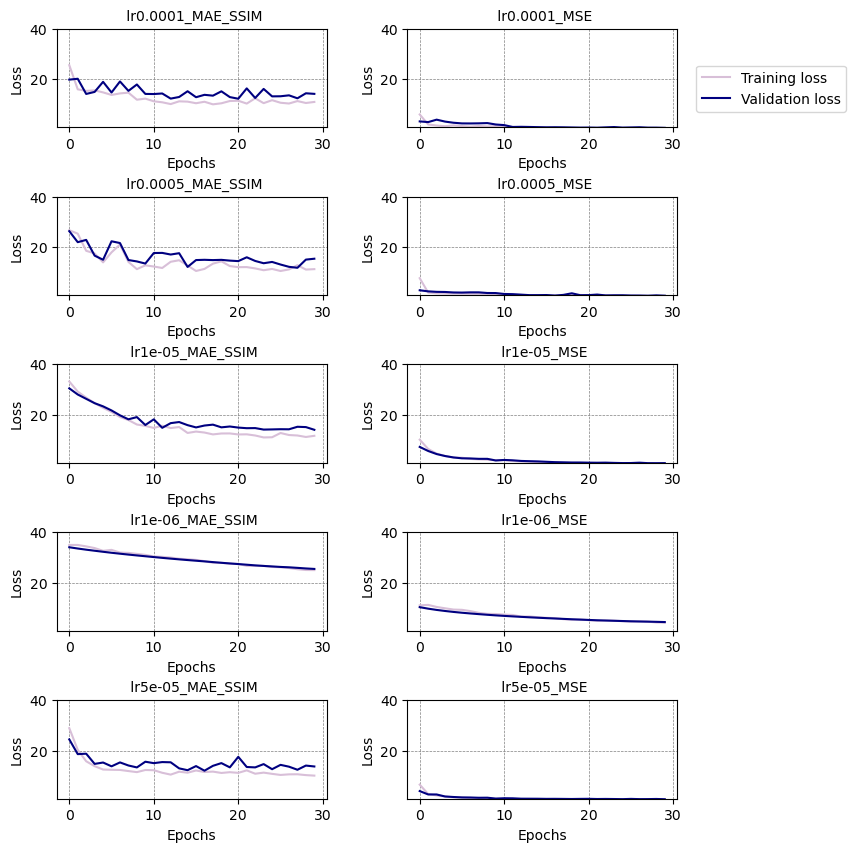

In [ ]:
x_values = np.arange(0,30)
fig, axes = plt.subplots(5,2, figsize=(8,10))

axes = axes.flatten()

for i in range(10):
    train_element = list(train_losses[i].values())[0]
    val_element = list(val_losses[i].values())[0]
    axes[i].plot(x_values, train_element, color = 'thistle')
    axes[i].plot(x_values, val_element, color = 'navy')
    axes[i].set_title(f'{list(train_losses[i].keys())[0][5:]}', fontsize=10)
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Loss')
    axes[i].set_ylim(1,40)
    axes[i].grid(True, color='gray', linestyle = '--', lw=0.5)

fig.legend(['Training loss', 'Validation loss'], bbox_to_anchor = (1.12,0.85), loc='upper right', fontsize=10, frameon=True, markerscale=1.5)
plt.subplots_adjust( hspace=0.7, wspace=0.3)
plt.show()

### Lowest validation loss

During model selection, two different loss functions were evaluated: Mean Squared Error (MSE) and a combined loss combining Mean Absolute Error (MAE) with Structural Similarity Index Measure (SSIM). The results for each model were logged as JSON files, with each model trained over 30 epochs.

 The code below finds the models that achieved the lowest validation loss for each of the loss functions. For each selected models, the corresponding learning rate and the computed loss value are printed.

Each file in the 'results' folder is a list containing multiple dictionaries, one dictionary per epoch.

In [ ]:
results_path = '../../4D_models/4D_model_weights/results'

# Initialize tracking variables
lowest_loss = np.inf
lowest_loss_file = None
lowest_loss_data = None

MSE_results = []
MAE_SSIM_results = []

# Iterate over all result files in the directory
for filename in os.listdir(results_path):
    if filename.endswith('.json') and filename.startswith('MSE'):
        results_file = os.path.join(results_path, filename)

        # Opening files containing results from models trained with MSE
        with open(results_file, 'r') as file:
            data = json.load(file)
            num_models = len(data) // 30 # number of epochs
            for i in range(num_models):
                run = data[i*30 : (i+1)*30]
                MSE_results.append({
                    'loss': run[-1]['loss'], # Use final epoch's validation loss
                    'learning rate': run[-1]['learning rate'],
                    'loss function': 'MSE'
                    })
    else:
        # Assumes non-MSE files are from models trained with MAE+SSIM loss
        results_file = os.path.join(results_path, filename)
        with open(results_file, 'r') as file:
            data = json.load(file)
            num_models = len(data) // 30 # number of epochs
            for i in range(num_models):
                run = data[i*30 : (i+1)*30]
                MAE_SSIM_results.append({
                    'loss': run[-1]['loss'], # Final epoch's validation loss
                    'learning rate': run[-1]['learning rate'],
                    'loss function': 'MAE+SSIM'
                    })

# Find the best model (lowest loss) for each loss function
best_MSE_result = min(MSE_results, key=lambda d: d['loss'])
print(best_MSE_result)

best_MAE_result = min(MAE_SSIM_results, key=lambda d: d['loss'])
print(best_MAE_result)

{'loss': 0.8020957112312317, 'learning rate': 5e-05, 'loss function': 'MSE'}
{'loss': 13.739818572998047, 'learning rate': 5e-05, 'loss function': 'MAE+SSIM'}


### Visualizing predictions from the best performing models
After determining the best performing models from each loss function, predictions are generated for each model. Since these loss functions focus different aspects of the reconstruction (e.g., pixel-wise accuracy vs. perceptual similarity), visualizing the model predictions on validation data provides a better insight on how well the reconstruction is to the human eye.

In [5]:
X_val_path = '../../preprocessed_4d/ls_val'
y_val_path = '../../preprocessed_4d/epi_val'


X_val_files = [f for f in os.listdir(X_val_path) if f.endswith('.pt')]
X_val = [torch.load(os.path.join(X_val_path, f)) for f in X_val_files]

y_val_files = [f for f in os.listdir(y_val_path) if f.endswith('.pt')]
y_val = [torch.load(os.path.join(y_val_path, f)) for f in y_val_files]

C:\Users\Caroline\AppData\Local\Temp\ipykernel_19060\579072664.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_val = [torch.load(os.path.join(X_val_path, f)) for f in 

In [6]:
val_dataset = CreateDataset(X_val, y_val)

#### Best MSE model

In [13]:
best_MSE_model = UNet4D()

checkpoint_MSE = torch.load('../../4D_models/4D_model_weights/MSE_lr5e-5/weights_model_lr5e-05_epoch30.pth', map_location=device)
best_MSE_model.load_state_dict(checkpoint_MSE['model_state_dict'])

best_MSE_model.eval()

best_MSE_model.to(device=device)

set_seed(42)
batch_size = 1
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(42))
preds_MSE, true_MSE = predictions(best_MSE_model, val_loader)

C:\Users\Caroline\AppData\Local\Temp\ipykernel_19060\4003820719.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_MSE = torch.load('../../4D_models/4D_model_wei

#### Best MAE+SSIM model

In [15]:
best_MAESSIM_model = UNet4D()

checkpoint_MAESSIM = torch.load('../../4D_models/4D_model_weights/MAE_SSIM_lr_5e-5/weights_model_lr5e-05_epoch30.pth', map_location=device)
best_MAESSIM_model.load_state_dict(checkpoint_MAESSIM['model_state_dict'])

best_MAESSIM_model.eval()

best_MAESSIM_model.to(device=device)

set_seed(42)
batch_size = 1
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(42))
preds_MAE, true_MAE = predictions(best_MAESSIM_model, val_loader)

C:\Users\Caroline\AppData\Local\Temp\ipykernel_19060\2267597439.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_MAESSIM = torch.load('../../4D_models/4D_model

### Plotting predictions

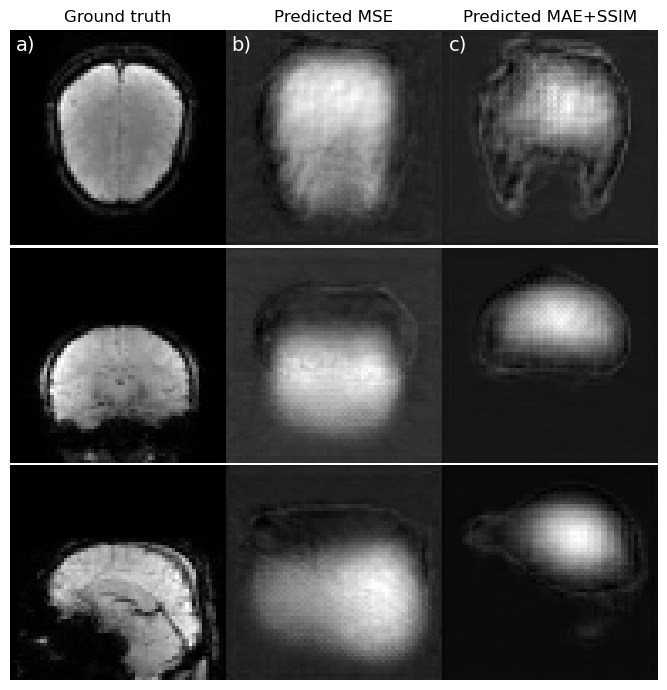

In [16]:
preds_cpu_MSE = preds_MSE[0].cpu()
preds_cpu_MAE = preds_MAE[0].cpu()
true_cpu = true_MSE[0].cpu()
preds0_MSE= preds_cpu_MSE.squeeze(0,1)
preds0_MAE= preds_cpu_MAE.squeeze(0,1)
true0= true_cpu.squeeze(0,1)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize =(7,7))

i = 32

ax[0,0].imshow(np.rot90(true0[12,:,:,i]), cmap='gray')
ax[0,0].axis('off')
ax[0,0].set_title('Ground truth')
ax[0,0].text(7,1,'a)', ha='right', va='top', fontsize=14, color='white')

ax[0,1].imshow(np.rot90(preds0_MSE[12,:,:,i]), cmap='gray')
ax[0,1].axis('off')
ax[0,1].set_title('Predicted MSE')
ax[0,1].text(7,1,'b)', ha='right', va='top', fontsize=14, color='white')

ax[0,2].imshow(np.rot90(preds0_MAE[12,:,:,i]), cmap='gray')
ax[0,2].axis('off')
ax[0,2].set_title('Predicted MAE+SSIM')
ax[0,2].text(7,1,'c)', ha='right', va='top', fontsize=14, color='white')

ax[1,0].imshow(np.rot90(true0[12,:,i,:]), cmap='gray')
ax[1,0].axis('off')
ax[1,1].imshow(np.rot90(preds0_MSE[12,:,i,:]), cmap='gray')
ax[1,1].axis('off')
ax[1,2].imshow(np.rot90(preds0_MAE[12,:,i,:]), cmap='gray')
ax[1,2].axis('off')

ax[2,0].imshow(np.rot90(true0[12,i,:,:]), cmap='gray')
ax[2,0].axis('off')
ax[2,1].imshow(np.rot90(preds0_MSE[12,i,:,:]), cmap='gray')
ax[2,1].axis('off')
ax[2,2].imshow(np.rot90(preds0_MAE[12,i,:,:]), cmap='gray')
ax[2,2].axis('off')
plt.tight_layout()

plt.subplots_adjust( hspace=0.01, wspace=-0.09)
plt.show()

### Enhanced version of the selected model's loss

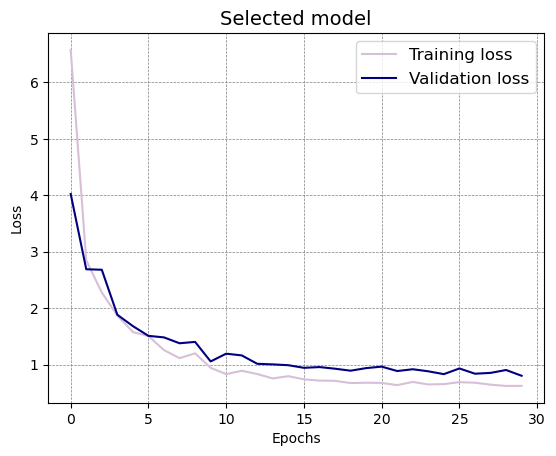

In [12]:
lowst_train = list(train_losses[-1].values())[0] # model selected based on MSE
lowst_val = list(val_losses[-1].values())[0]

plt.plot(x_values, lowst_train, color = 'thistle', label = 'Training loss')
plt.plot(x_values, lowst_val, color = 'navy', label = 'Validation loss')
plt.grid(True, color='gray', linestyle = '--', lw=0.5)
plt.legend(loc='upper right', fontsize=12, frameon=True, markerscale=1.5)
plt.title('Selected model', fontsize=14)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

In [ ]:


def calc_MAE(preds, label):
    mae = MeanAbsoluteError()
    return mae(preds, label)

def calc_MSE(preds, label):
    mse = MeanSquaredError()
    return mse(preds, label)

def calc_SSIM_eval(preds, true):
    preds = preds.squeeze(0,1)
    true = true.squeeze(0,1)
    metric = SSIM(data_range=1)
    metric.update((preds, true))
    ssim_value = metric.compute()
    return ssim_value

In [20]:
print('Performance of loss function: MSE')
print(f'MSE: {calc_MSE(preds_cpu_MSE, true_cpu)}')
print(f'MAE: {calc_MAE(preds_cpu_MSE, true_cpu)}')
print(f'SSIM: {calc_SSIM_eval(preds_cpu_MSE, true_cpu)}')

print('****')

print('Performance of loss function: MAE+SSIM')
print(f'MSE: {calc_MSE(preds_cpu_MAE, true_cpu)}')
print(f'MAE: {calc_MAE(preds_cpu_MAE, true_cpu)}')
print(f'SSIM: {calc_SSIM_eval(preds_cpu_MAE, true_cpu)}')

Performance of loss function: MSE
MSE: 0.008020956069231033
MAE: 0.043257541954517365
SSIM: 0.5533426081853222
****
Performance of loss function: MAE+SSIM
MSE: 0.02992168255150318
MAE: 0.07672426849603653
SSIM: 0.544064695303173
